Estimate feature importance by randomly bumping every value of a single feature, and recording how your overall fitness function degrades.

So if your first feature x1,i is continuously-valued and scaled to [0,1], then you might add rand(0,1)−0.5 to each training example's value for the first feature. Then look for how much your R2 decreases. This effectively excludes a feature from your training data, but deals with cross-interactions better than literally deleting the feature.

Then rank your features by fitness function degradation, and make a pretty bar chart. At least some of the most important features should pass a gut-check, given your knowledge of the problem domain. And this also lets you be nicely surprised by informative features that you may not have expected.

This sort of feature importance test works for all black-box models, including neural networks and large CART ensembles. In my experience, feature importance is the first step in understanding what a model is really doing.


Recurrent Neural Networks:
http://people.idsia.ch/~juergen/rnn.html

http://stackoverflow.com/questions/10565868/what-is-the-criteria-for-choosing-number-of-hidden-layers-and-nodes-in-hidden-la

Hinton diagram
start with average of num of input and output nodes *.66
princ compoent of features and num of pc that captures 80% of variance is number of nodes.
typically one hidden or two hidden good enough





In [1]:
#Get market price data

from os import listdir
from os.path import isfile, join
import os
import glob
import datetime
import pandas as pd
from dateutil.parser import parse
from pandas.io.data import DataReader

symbols_list = ['^GSPC', 'OIL', 'GLD', '^TYX', '^FVX', '^TNX' ]
d = {}

for ticker in symbols_list:
    d[ticker] = DataReader(ticker, "yahoo", '2002-12-31')
pan = pd.Panel(d)
Market_Adj_Close = pan.minor_xs('Adj Close')


Market_Adj_Close = Market_Adj_Close.rename(columns={'^GSPC': 'PX_SP500', 'GLD': 'PX_GLD', 'OIL': 'PX_OIL', '^FVX': 'PX_5_Yr_Yield', '^TNX': 'PX_10_yr_Yield', '^TYX': 'PX_30_yr_Yield'})

print(Market_Adj_Close)


                PX_GLD  PX_OIL  PX_5_Yr_Yield     PX_SP500  PX_10_yr_Yield  \
Date                                                                         
2002-12-31         NaN     NaN          2.730   879.820007           3.818   
2003-01-02         NaN     NaN          2.979   909.030029           4.032   
2003-01-03         NaN     NaN          2.989   908.590027           4.038   
2003-01-06         NaN     NaN          3.043   929.010010           4.066   
2003-01-07         NaN     NaN          2.991   922.929993           4.025   
2003-01-08         NaN     NaN          2.947   909.929993           3.981   
2003-01-09         NaN     NaN          3.144   927.570007           4.148   
2003-01-10         NaN     NaN          3.146   927.570007           4.152   
2003-01-13         NaN     NaN          3.103   926.260010           4.128   
2003-01-14         NaN     NaN          3.043   931.659973           4.085   
2003-01-15         NaN     NaN          3.039   918.219971      

In [2]:
Market_Adj_Close['Date'] = Market_Adj_Close.index

In [3]:
type(Market_Adj_Close.Date[0])

pandas.tslib.Timestamp

In [4]:
SKIP = 1

if SKIP != 1:
    #create list of all dates from 12/31/99 to 07/31/2015
    dt = datetime.datetime(1999, 12, 31)
    end = datetime.datetime(2015, 7, 31)
    step = datetime.timedelta(days=1)
    
    dates = []
    
    while dt < end:
    #    dates.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
        dates.append(dt.strftime('%Y-%m-%d'))
        dt += step
        
    #write list of dates into master data file (data_file.txt)
    type( dates[0] )
    dates[0]
    
    data_file = open("data_file.txt", "w")
    
    data_file.write('Date' +"\n")
    for date in dates:
        data_file.write(date + ",\n")              
    
    data_file.close()
    
    # create 2 lists of daily filenames and weekly filenames in directory
    daily_directory = '/Users/wilsonkung/DataScience/metis/projects/project_kojak_wilsonkung/data/Daily'
    weekly_directory =  '/Users/wilsonkung/DataScience/metis/projects/project_kojak_wilsonkung/data/weekly'
    
    daily_files = [ f for f in listdir(daily_directory) if isfile(join(daily_directory, f)) and f[0] not in ['_', '.'] ]
    weekly_files = [ f for f in listdir(weekly_directory) if isfile(join(weekly_directory, f)) and f[0] not in ['_', '.'] ]
    
    data_df = pd.DataFrame.from_csv('data_file.txt',index_col=False)
    #data_df = pandas.read_csv('data_file.txt')
    
    
    #data_df = data_df.merge(temp_df[['Date','Values']], on='Date', how='left'
    
    x = 0
    
    for file in daily_files:
        print ( 'processing: '+ file + ' ' + str(x) )
        temp_df = pd.read_csv('./data/Daily/' + file)
        data_df = data_df.merge(temp_df[['Date','Values']], on='Date', how='left')
        data_df = data_df.rename(columns = { 'Values': 'D_' + file.split('.')[0] })
        x += 1
        
    #    data_df = data_df.merge(temp_df[list('Value')] , on='Date', how='left')
    #
    for file in weekly_files:
        print ( 'processing: '+ file + ' ' + str(x) )
        temp_df = pd.read_csv('./data/weekly/' + file)
        data_df = data_df.merge(temp_df[['Date','Values']], on='Date', how='left')
        data_df = data_df.rename(columns = { 'Values': 'W_' + file.split('.')[0] })
        x += 1

    data_df.to_csv('combined_data.csv')

FREQ =  5 #1
ASSUMED_WEEKLY_DATA_RELEASE = 'WEDNESDAY'
BEG_DATE = datetime.datetime(2002, 12, 31)


#datetime.datetime.today()
#datetime.datetime.today().weekday()

#################################################################################

PATH = '/Users/wilsonkung/DataScience/metis/projects/project_kojak_wilsonkung/'
data_df = pd.read_csv(PATH+'combined_data.csv')

cols = [c for c in data_df.columns if c[:2] == 'D_' or c == 'Date']
#
#
daily_data_df = data_df[cols]

daily_data_df_subset = daily_data_df[ pd.to_datetime( daily_data_df['Date']) >= BEG_DATE ]

feature_count = daily_data_df_subset.isnull().sum()

In [5]:
feature_count.sort(ascending = 'False')

In [6]:
pd.set_option('display.height', 1200)
pd.set_option('display.max_rows', 1200)

height has been deprecated.



In [7]:
feature_count

Date                             0
D_DFF                            3
D_USEPUINDXD                    22
D_WLEMUINDXD                    22
D_CFSI                          24
D_BAMLEMRECRPIEMEAOAS         1328
D_BAMLH0A1HYBB                1328
D_BAMLH0A0HYM2SYTW            1328
D_BAMLH0A0HYM2EY              1328
D_BAMLH0A0HYM2                1328
D_BAMLEMCBPIEY                1328
D_BAMLEMCBPIOAS               1328
D_BAMLEMCBPISYTW              1328
D_BAMLEMCBPITRIV              1328
D_BAMLEMUBCRPIUSTRIV          1328
D_BAMLEMUBCRPIUSSYTW          1328
D_BAMLEMUBCRPIUSOAS           1328
D_BAMLEMEBCRPIEEY             1328
D_BAMLEMEBCRPIEOAS            1328
D_BAMLEM5BCOCRPITRIV          1328
D_BAMLEM5BCOCRPISYTW          1328
D_BAMLEM5BCOCRPIOAS           1328
D_BAMLEM5BCOCRPIEY            1328
D_BAMLH0A3HYC                 1328
D_BAMLEM3BRRBBCRPIEY          1328
D_BAMLEM3BRRBBCRPIOAS         1328
D_BAMLEM3BRRBBCRPISYTW        1328
D_BAMLEM3BRRBBCRPITRIV        1328
D_BAMLH0A2HYBSYTW   

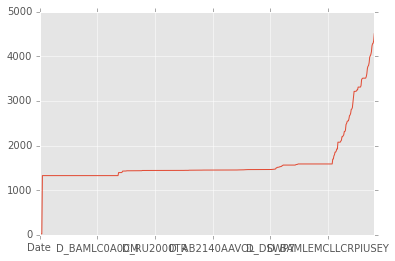

In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')


%matplotlib inline  
feature_count.plot()

# cutoff is around 1,600 nans so get rid of columns with more than 1,600 'nan'


In [9]:
daily_data_df_subset.shape

(4595, 581)

In [10]:
cols_to_delete = feature_count[feature_count >= 1600].index.values

In [11]:
type(cols_to_delete)

numpy.ndarray

In [12]:
#list of columns with too many missing values
list(cols_to_delete)

['D_RIFSPPFAAD07NB',
 'D_RVXCLS',
 'D_RIFSPPFAAD15NB',
 'D_RIFSPPNA2P2D60NB',
 'D_DFII20',
 'D_DTP20J25',
 'D_ARINFL',
 'D_DCPN2M',
 'D_RIFSPPNAAD60NB',
 'D_DJTA',
 'D_SP500',
 'D_DJCA',
 'D_DJIA',
 'D_DJUA',
 'D_DTP10L15',
 'D_USINFL',
 'D_DFEDTARL',
 'D_DFEDTARU',
 'D_DTP10J16',
 'D_DGS30',
 'D_DDFUELUSGULF',
 'D_DDFUELNYH',
 'D_DTP10L16',
 'D_DTP10J17',
 'D_RIFSPPNA2P2D90NB',
 'D_OVXCLS',
 'D_DCPN3M',
 'D_RIFSPPNAAD90NB',
 'D_DTP10L17',
 'D_EVZCLS',
 'D_VXVCLS',
 'D_DTP10J18',
 'D_GVZCLS',
 'D_DTB1YR',
 'D_DTP10L18',
 'D_DTP10J19',
 'D_DTP10L19',
 'D_DTP20J28',
 'D_DTP20J27',
 'D_DTP20J26',
 'D_DTP20J29',
 'D_DTP10J20',
 'D_DTP30F40',
 'D_DFII30',
 'D_VXAZNCLS',
 'D_VXIBMCLS',
 'D_VXAPLCLS',
 'D_VXGOGCLS',
 'D_VXGSCLS',
 'D_DTP10L20',
 'D_DTP10J21',
 'D_DTP30F41',
 'D_VXEEMCLS',
 'D_VXEWZCLS',
 'D_VXFXICLS',
 'D_VXGDXCLS',
 'D_VXSLVCLS',
 'D_VXXLECLS',
 'D_DTP5A16',
 'D_DTP10L21',
 'D_DTP10J22',
 'D_DTP30F42',
 'D_DTP5A17',
 'D_DTP10L22',
 'D_DTP10J23',
 'D_DTP30F43',
 'D_DTP5A18',


In [13]:
daily_data_df_subset_clean = daily_data_df_subset.drop(cols_to_delete, axis=1)
daily_data_df_subset_clean.head(5)

,Date,D_AAA10Y,D_AAAFF,D_AB1020AAAMT,D_AB1020AAVOL,D_AB14AAAMT,D_AB14AAVOL,D_AB2140AAAMT,D_AB2140AAVOL,D_AB4180AAAMT,...,D_WILLREITPR,D_WILLRESIND,D_WILLRESIPR,D_WILLSMLCAP,D_WILLSMLCAPGR,D_WILLSMLCAPGRPR,D_WILLSMLCAPPR,D_WILLSMLCAPVAL,D_WILLSMLCAPVALPR,D_WLEMUINDXD
1096,2002-12-31,2.26,4.93,2139,162,17103,726,2820,222,1424,...,114.67,222.10,95.46,19798.40,12012.57,1567.92,2213.45,29194.80,2876.27,786.39873
1097,2003-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.29983
1098,2003-01-02,2.16,4.93,2782,187,14934,673,5433,262,2451,...,115.17,223.49,96.00,20284.19,12342.56,1610.99,2267.69,29829.23,2938.62,188.18226
1099,2003-01-03,2.18,5.11,2041,141,12105,549,6455,291,3684,...,116.11,225.11,96.69,20210.90,12288.08,1603.87,2259.48,29744.43,2930.22,148.89540
1100,2003-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,635.94004


In [14]:
Market_Adj_Close.head(3)

,PX_GLD,PX_OIL,PX_5_Yr_Yield,PX_SP500,PX_10_yr_Yield,PX_30_yr_Yield,Date
Date,,,,,,,
2002-12-31,NaN,NaN,2.730,879.820007,3.818,4.783,2002-12-31
2003-01-02,NaN,NaN,2.979,909.030029,4.032,4.957,2003-01-02
2003-01-03,NaN,NaN,2.989,908.590027,4.038,4.954,2003-01-03


In [15]:
#Change datetime to string
str(Market_Adj_Close['Date'][0]).split()[0]
Market_Adj_Close.Date = Market_Adj_Close.Date.map(lambda x: x.strftime('%Y-%m-%d'))

In [16]:
type( Market_Adj_Close['Date'][0] )

str

In [17]:
#add market prices
merged_data = pd.merge(daily_data_df_subset_clean, Market_Adj_Close, on = 'Date')
#daily_data_df_subset_clean = daily_data_df_subset_clean.merge(Market_Adj_Close, left_index=True, right_index=True, how='left')

In [18]:
#problems
merged_data.head(10)

,Date,D_AAA10Y,D_AAAFF,D_AB1020AAAMT,D_AB1020AAVOL,D_AB14AAAMT,D_AB14AAVOL,D_AB2140AAAMT,D_AB2140AAVOL,D_AB4180AAAMT,...,D_WILLSMLCAPPR,D_WILLSMLCAPVAL,D_WILLSMLCAPVALPR,D_WLEMUINDXD,PX_GLD,PX_OIL,PX_5_Yr_Yield,PX_SP500,PX_10_yr_Yield,PX_30_yr_Yield
0,2002-12-31,2.26,4.93,2139,162,17103,726,2820,222,1424,...,2213.45,29194.80,2876.27,786.39873,NaN,NaN,2.730,879.820007,3.818,4.783
1,2003-01-02,2.16,4.93,2782,187,14934,673,5433,262,2451,...,2267.69,29829.23,2938.62,188.18226,NaN,NaN,2.979,909.030029,4.032,4.957
2,2003-01-03,2.18,5.11,2041,141,12105,549,6455,291,3684,...,2259.48,29744.43,2930.22,148.89540,NaN,NaN,2.989,908.590027,4.038,4.954
3,2003-01-06,2.14,5.01,3581,202,13351,577,9370,431,4149,...,2296.79,30252.03,2980.17,295.76212,NaN,NaN,3.043,929.010010,4.066,4.978
4,2003-01-07,2.18,5.02,1167,99,11082,519,8123,399,3928,...,2280.19,29971.19,2952.50,248.73522,NaN,NaN,2.991,922.929993,4.025,4.961
5,2003-01-08,2.18,4.89,1640,116,10987,469,6101,288,5304,...,2252.94,29641.70,2919.64,81.20085,NaN,NaN,2.947,909.929993,3.981,4.921
6,2003-01-09,2.11,5.01,1082,85,10230,467,6929,322,2796,...,2293.85,30107.55,2965.39,147.64174,NaN,NaN,3.144,927.570007,4.148,5.061
7,2003-01-10,2.12,5.03,1881,123,12446,581,9170,445,5825,...,2298.14,30117.31,2966.24,140.02851,NaN,NaN,3.146,927.570007,4.152,5.056
8,2003-01-13,2.11,5.00,1135,81,14494,679,8704,480,2694,...,2294.54,30073.28,2961.54,73.28117,NaN,NaN,3.103,926.260010,4.128,5.028
9,2003-01-14,2.13,4.99,3005,143,14207,615,8721,548,2741,...,2305.79,30216.90,2975.65,135.55772,NaN,NaN,3.043,931.659973,4.085,4.998


In [19]:
daily_data_df_subset_clean_nona = merged_data.dropna()

In [20]:
daily_data_df_subset_clean_nona.head()

,Date,D_AAA10Y,D_AAAFF,D_AB1020AAAMT,D_AB1020AAVOL,D_AB14AAAMT,D_AB14AAVOL,D_AB2140AAAMT,D_AB2140AAVOL,D_AB4180AAAMT,...,D_WILLSMLCAPPR,D_WILLSMLCAPVAL,D_WILLSMLCAPVALPR,D_WLEMUINDXD,PX_GLD,PX_OIL,PX_5_Yr_Yield,PX_SP500,PX_10_yr_Yield,PX_30_yr_Yield
913,2006-08-16,0.80,0.50,2090,74,26287,1091,10960,479,3643,...,4255.36,58654.61,5320.67,7.21046,62.490002,49.189999,4.806,1295.430054,4.871,5.001
914,2006-08-17,0.80,0.47,3433,108,24991,1112,10514,484,4494,...,4263.86,58696.20,5324.03,11.84703,61.029999,48.360001,4.812,1297.479980,4.867,4.999
916,2006-08-21,0.81,0.39,1492,89,30854,1284,27352,937,4355,...,4239.33,58448.90,5301.28,12.04752,62.439999,49.320000,4.767,1297.520020,4.819,4.964
917,2006-08-22,0.80,0.38,740,31,27544,1153,12880,478,4430,...,4251.50,58600.03,5314.94,9.87955,62.049999,49.230000,4.763,1298.819946,4.811,4.950
918,2006-08-23,0.80,0.37,891,50,23844,999,13022,521,3665,...,4203.77,57943.27,5255.00,13.96537,61.830002,48.330002,4.777,1292.989990,4.819,4.953


In [21]:
indexed_daily_data_df_subset_clean_nona = daily_data_df_subset_clean_nona.set_index(['Date'])

In [22]:
indexed_daily_data_df_subset_clean_nona.head(5)

,D_AAA10Y,D_AAAFF,D_AB1020AAAMT,D_AB1020AAVOL,D_AB14AAAMT,D_AB14AAVOL,D_AB2140AAAMT,D_AB2140AAVOL,D_AB4180AAAMT,D_AB4180AAVOL,...,D_WILLSMLCAPPR,D_WILLSMLCAPVAL,D_WILLSMLCAPVALPR,D_WLEMUINDXD,PX_GLD,PX_OIL,PX_5_Yr_Yield,PX_SP500,PX_10_yr_Yield,PX_30_yr_Yield
Date,,,,,,,,,,,,,,,,,,,,,
2006-08-16,0.80,0.50,2090,74,26287,1091,10960,479,3643,148,...,4255.36,58654.61,5320.67,7.21046,62.490002,49.189999,4.806,1295.430054,4.871,5.001
2006-08-17,0.80,0.47,3433,108,24991,1112,10514,484,4494,202,...,4263.86,58696.20,5324.03,11.84703,61.029999,48.360001,4.812,1297.479980,4.867,4.999
2006-08-21,0.81,0.39,1492,89,30854,1284,27352,937,4355,186,...,4239.33,58448.90,5301.28,12.04752,62.439999,49.320000,4.767,1297.520020,4.819,4.964
2006-08-22,0.80,0.38,740,31,27544,1153,12880,478,4430,170,...,4251.50,58600.03,5314.94,9.87955,62.049999,49.230000,4.763,1298.819946,4.811,4.950
2006-08-23,0.80,0.37,891,50,23844,999,13022,521,3665,154,...,4203.77,57943.27,5255.00,13.96537,61.830002,48.330002,4.777,1292.989990,4.819,4.953


In [23]:
#Calc daily differences and drop first row of na's

indexed_daily_data_df_subset_clean_nona_diffs = indexed_daily_data_df_subset_clean_nona.diff().dropna()
indexed_daily_data_df_subset_clean_nona_diffs.head(10)

X_Y_Data_Diffs = indexed_daily_data_df_subset_clean_nona_diffs
X_Y_Data_Diffs.PX_5_Yr_Yield

Date
2006-08-17    0.006
2006-08-21   -0.045
2006-08-22   -0.004
2006-08-23    0.014
2006-08-24   -0.007
2006-08-25   -0.016
2006-08-29    0.003
2006-08-30   -0.022
2006-08-31   -0.043
2006-09-01   -0.012
2006-09-06    0.066
2006-09-07   -0.011
2006-09-08   -0.032
2006-09-11    0.030
2006-09-12   -0.025
2006-09-13   -0.010
2006-09-14    0.039
2006-09-15    0.018
2006-09-19   -0.063
2006-09-20    0.000
2006-09-21   -0.094
2006-09-22   -0.051
2006-09-25   -0.033
2006-09-26    0.039
2006-09-27    0.005
2006-09-28    0.020
2006-09-29    0.009
2006-10-02   -0.029
2006-10-03    0.000
2006-10-04   -0.063
2006-10-05    0.051
2006-10-10    0.159
2006-10-11    0.044
2006-10-12   -0.007
2006-10-13    0.026
2006-10-16   -0.018
2006-10-17   -0.013
2006-10-19    0.015
2006-10-20    0.004
2006-10-24    0.045
2006-10-25   -0.050
2006-10-26   -0.058
2006-10-27   -0.061
2006-10-30    0.005
2006-10-31   -0.069
2006-11-01   -0.051
2006-11-02    0.032
2006-11-06    0.136
2006-11-08   -0.083
2006-11-09   -0

In [24]:
X_Y_Data_Diffs.head()

,D_AAA10Y,D_AAAFF,D_AB1020AAAMT,D_AB1020AAVOL,D_AB14AAAMT,D_AB14AAVOL,D_AB2140AAAMT,D_AB2140AAVOL,D_AB4180AAAMT,D_AB4180AAVOL,...,D_WILLSMLCAPPR,D_WILLSMLCAPVAL,D_WILLSMLCAPVALPR,D_WLEMUINDXD,PX_GLD,PX_OIL,PX_5_Yr_Yield,PX_SP500,PX_10_yr_Yield,PX_30_yr_Yield
Date,,,,,,,,,,,,,,,,,,,,,
2006-08-17,0.00,-0.03,1343,34,-1296,21,-446,5,851,54,...,8.50,41.59,3.36,4.63657,-1.460003,-0.829998,0.006,2.049926,-0.004,-0.002
2006-08-21,0.01,-0.08,-1941,-19,5863,172,16838,453,-139,-16,...,-24.53,-247.30,-22.75,0.20049,1.410000,0.959999,-0.045,0.040040,-0.048,-0.035
2006-08-22,-0.01,-0.01,-752,-58,-3310,-131,-14472,-459,75,-16,...,12.17,151.13,13.66,-2.16797,-0.390000,-0.090000,-0.004,1.299926,-0.008,-0.014
2006-08-23,0.00,-0.01,151,19,-3700,-154,142,43,-765,-16,...,-47.73,-656.76,-59.94,4.08582,-0.219997,-0.899998,0.014,-5.829956,0.008,0.003
2006-08-24,0.00,-0.01,2448,100,-562,45,-3610,-119,179,8,...,-1.67,-33.85,-3.29,45.88822,-0.080002,0.570000,-0.007,3.070069,-0.016,-0.014


In [25]:
X_Y_Data_Diffs['Chg_10_yr_Yield'] = X_Y_Data_Diffs['PX_10_yr_Yield']

X_Y_Data_Diffs.Chg_10_yr_Yield[X_Y_Data_Diffs.Chg_10_yr_Yield <= 0] = 0
X_Y_Data_Diffs.Chg_10_yr_Yield[X_Y_Data_Diffs.Chg_10_yr_Yield > 0] = 1


X_Y_Data_Diffs['Chg_5_Yr_Yield'] = X_Y_Data_Diffs['PX_5_Yr_Yield']

X_Y_Data_Diffs.Chg_5_Yr_Yield[X_Y_Data_Diffs.Chg_5_Yr_Yield <= 0] = 0
X_Y_Data_Diffs.Chg_5_Yr_Yield[X_Y_Data_Diffs.Chg_5_Yr_Yield > 0] = 1


X_Y_Data_Diffs['Chg_30_yr_Yield'] = X_Y_Data_Diffs['PX_30_yr_Yield']

X_Y_Data_Diffs.Chg_30_yr_Yield[X_Y_Data_Diffs.Chg_30_yr_Yield <= 0] = 0
X_Y_Data_Diffs.Chg_30_yr_Yield[X_Y_Data_Diffs.Chg_30_yr_Yield > 0] = 1


X_Y_Data_Diffs['Chg_GLD'] = X_Y_Data_Diffs['PX_GLD']

X_Y_Data_Diffs.Chg_GLD[X_Y_Data_Diffs.Chg_GLD <= 0] = 0
X_Y_Data_Diffs.Chg_GLD[X_Y_Data_Diffs.Chg_GLD > 0] = 1


X_Y_Data_Diffs['Chg_OIL'] = X_Y_Data_Diffs['PX_OIL']

X_Y_Data_Diffs.Chg_OIL[X_Y_Data_Diffs.Chg_OIL <= 0] = 0
X_Y_Data_Diffs.Chg_OIL[X_Y_Data_Diffs.Chg_OIL > 0] = 1


X_Y_Data_Diffs['Chg_SP500'] = X_Y_Data_Diffs['PX_SP500']

X_Y_Data_Diffs.Chg_SP500[X_Y_Data_Diffs.Chg_SP500 <= 0] = 0
X_Y_Data_Diffs.Chg_SP500[X_Y_Data_Diffs.Chg_SP500 > 0] = 1

In [26]:
X_Y_Data_Diffs.PX_10_yr_Yield

Date
2006-08-17   -0.004
2006-08-21   -0.048
2006-08-22   -0.008
2006-08-23    0.008
2006-08-24   -0.016
2006-08-25   -0.012
2006-08-29   -0.008
2006-08-30   -0.020
2006-08-31   -0.031
2006-09-01   -0.006
2006-09-06    0.075
2006-09-07   -0.006
2006-09-08   -0.024
2006-09-11    0.028
2006-09-12   -0.026
2006-09-13   -0.008
2006-09-14    0.028
2006-09-15    0.005
2006-09-19   -0.061
2006-09-20   -0.008
2006-09-21   -0.081
2006-09-22   -0.051
2006-09-25   -0.042
2006-09-26    0.030
2006-09-27    0.009
2006-09-28    0.032
2006-09-29    0.007
2006-10-02   -0.015
2006-10-03   -0.002
2006-10-04   -0.051
2006-10-05    0.043
2006-10-10    0.140
2006-10-11    0.036
2006-10-12   -0.006
2006-10-13    0.028
2006-10-16   -0.018
2006-10-17   -0.010
2006-10-19    0.008
2006-10-20   -0.002
2006-10-24    0.040
2006-10-25   -0.051
2006-10-26   -0.052
2006-10-27   -0.046
2006-10-30   -0.002
2006-10-31   -0.067
2006-11-01   -0.045
2006-11-02    0.035
2006-11-06    0.113
2006-11-08   -0.076
2006-11-09    0

In [27]:
X_Y_Data_Diffs['Chg_10_yr_Yield']

Date
2006-08-17    0
2006-08-21    0
2006-08-22    0
2006-08-23    1
2006-08-24    0
2006-08-25    0
2006-08-29    0
2006-08-30    0
2006-08-31    0
2006-09-01    0
2006-09-06    1
2006-09-07    0
2006-09-08    0
2006-09-11    1
2006-09-12    0
2006-09-13    0
2006-09-14    1
2006-09-15    1
2006-09-19    0
2006-09-20    0
2006-09-21    0
2006-09-22    0
2006-09-25    0
2006-09-26    1
2006-09-27    1
2006-09-28    1
2006-09-29    1
2006-10-02    0
2006-10-03    0
2006-10-04    0
2006-10-05    1
2006-10-10    1
2006-10-11    1
2006-10-12    0
2006-10-13    1
2006-10-16    0
2006-10-17    0
2006-10-19    1
2006-10-20    0
2006-10-24    1
2006-10-25    0
2006-10-26    0
2006-10-27    0
2006-10-30    0
2006-10-31    0
2006-11-01    0
2006-11-02    1
2006-11-06    1
2006-11-08    0
2006-11-09    0
2006-11-10    0
2006-11-13    1
2006-11-14    0
2006-11-15    1
2006-11-16    1
2006-11-17    0
2006-11-20    0
2006-11-21    0
2006-11-22    0
2006-11-27    0
2006-11-28    0
2006-11-29    1
200

In [28]:
Chg_cols = [z for z in X_Y_Data_Diffs.columns if z[:4] == 'Chg_']

X_Y_Data_Diffs[Chg_cols] = X_Y_Data_Diffs[Chg_cols].astype(int)
type(X_Y_Data_Diffs.Chg_30_yr_Yield[0])

numpy.int64

In [29]:
#split out Y's from X_Y_Data_Diffs
Y_Data_Diffs = X_Y_Data_Diffs
X_Data_Diffs = X_Y_Data_Diffs

In [30]:
Y_cols = [c for c in Y_Data_Diffs.columns if c[:4] == 'Chg_']
Y_Data_Diffs = Y_Data_Diffs[Y_cols]

X_cols = [c for c in X_Data_Diffs.columns if c[:4] != 'Chg_']
X_Data_Diffs = X_Data_Diffs[X_cols]

In [31]:
Y_Data_Diffs.head()

,Chg_10_yr_Yield,Chg_5_Yr_Yield,Chg_30_yr_Yield,Chg_GLD,Chg_OIL,Chg_SP500
Date,,,,,,
2006-08-17,0,1,0,0,0,1
2006-08-21,0,0,0,1,1,1
2006-08-22,0,0,0,0,0,1
2006-08-23,1,1,1,0,0,0
2006-08-24,0,0,0,0,1,1


In [32]:
Y_Data_Diffs_Shifted = Y_Data_Diffs.shift(-1)
Y_Data_Diffs_Shifted = Y_Data_Diffs_Shifted[:-1] 

In [33]:
import numpy as np

Chg_cols = [z for z in Y_Data_Diffs_Shifted.columns if z[:4] == 'Chg_']

Y_Data_Diffs_Shifted[Chg_cols] = Y_Data_Diffs_Shifted[Chg_cols].astype(np.int32)
#type(X_Y_Data_Diffs.Chg_30_yr_Yield[0])

Y_Data_Diffs_Shifted.dtypes

Chg_10_yr_Yield    int32
Chg_5_Yr_Yield     int32
Chg_30_yr_Yield    int32
Chg_GLD            int32
Chg_OIL            int32
Chg_SP500          int32
dtype: object

In [34]:
X_Data_Diffs_Shifted = X_Data_Diffs[:-1]

In [35]:
Y_Data_Diffs_Shifted.shape, X_Data_Diffs_Shifted.shape

((1634, 6), (1634, 513))

In [36]:
Y_Data_Diffs_Shifted[Y_Data_Diffs_Shifted.isnull().any(axis=1)]

,Chg_10_yr_Yield,Chg_5_Yr_Yield,Chg_30_yr_Yield,Chg_GLD,Chg_OIL,Chg_SP500
Date,,,,,,


In [37]:
Y_Data_Diffs_Shifted.dtypes

Chg_10_yr_Yield    int32
Chg_5_Yr_Yield     int32
Chg_30_yr_Yield    int32
Chg_GLD            int32
Chg_OIL            int32
Chg_SP500          int32
dtype: object

In [38]:
X_Data_Diffs_Shifted

,D_AAA10Y,D_AAAFF,D_AB1020AAAMT,D_AB1020AAVOL,D_AB14AAAMT,D_AB14AAVOL,D_AB2140AAAMT,D_AB2140AAVOL,D_AB4180AAAMT,D_AB4180AAVOL,...,D_WILLSMLCAPPR,D_WILLSMLCAPVAL,D_WILLSMLCAPVALPR,D_WLEMUINDXD,PX_GLD,PX_OIL,PX_5_Yr_Yield,PX_SP500,PX_10_yr_Yield,PX_30_yr_Yield
Date,,,,,,,,,,,,,,,,,,,,,
2006-08-17,0.00,-0.03,1343,34,-1296,21,-446,5,851,54,...,8.50,41.59,3.36,4.63657,-1.460003,-0.829998,0.006,2.049926,-0.004,-0.002
2006-08-21,0.01,-0.08,-1941,-19,5863,172,16838,453,-139,-16,...,-24.53,-247.30,-22.75,0.20049,1.410000,0.959999,-0.045,0.040040,-0.048,-0.035
2006-08-22,-0.01,-0.01,-752,-58,-3310,-131,-14472,-459,75,-16,...,12.17,151.13,13.66,-2.16797,-0.390000,-0.090000,-0.004,1.299926,-0.008,-0.014
2006-08-23,0.00,-0.01,151,19,-3700,-154,142,43,-765,-16,...,-47.73,-656.76,-59.94,4.08582,-0.219997,-0.899998,0.014,-5.829956,0.008,0.003
2006-08-24,0.00,-0.01,2448,100,-562,45,-3610,-119,179,8,...,-1.67,-33.85,-3.29,45.88822,-0.080002,0.570000,-0.007,3.070069,-0.016,-0.014
2006-08-25,0.01,-0.01,-1228,-44,4821,112,7522,186,-1239,-39,...,0.87,-51.19,-4.91,-52.81307,0.020000,-0.060002,-0.016,-0.970093,-0.012,-0.007
2006-08-29,0.00,0.02,-572,-4,1243,30,-9877,-255,-340,-16,...,73.25,962.95,86.67,2.80078,-0.830001,-1.849998,0.003,9.190063,-0.008,-0.002
2006-08-30,0.00,-0.05,85,-9,-3648,-137,-1609,-65,-765,-36,...,22.18,234.45,19.47,11.09753,0.479999,0.429996,-0.022,1.089966,-0.020,-0.018
2006-08-31,-0.01,-0.09,2628,76,2919,131,367,-4,316,22,...,11.00,188.62,16.91,-9.19532,0.870003,-0.009998,-0.043,-1.550049,-0.031,-0.034


In [39]:
X_Data_Diffs_Shifted.tail(1)

,D_AAA10Y,D_AAAFF,D_AB1020AAAMT,D_AB1020AAVOL,D_AB14AAAMT,D_AB14AAVOL,D_AB2140AAAMT,D_AB2140AAVOL,D_AB4180AAAMT,D_AB4180AAVOL,...,D_WILLSMLCAPPR,D_WILLSMLCAPVAL,D_WILLSMLCAPVALPR,D_WLEMUINDXD,PX_GLD,PX_OIL,PX_5_Yr_Yield,PX_SP500,PX_10_yr_Yield,PX_30_yr_Yield
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-25,-0.01,0.01,180,8,-25,9,-94,-6,-50,1,...,-18.78,-346.42,-26.55,-1.06369,-0.149994,-0.14,0.038,-6.270019,0.022,0.01


In [40]:
from sklearn import preprocessing

#standardize the data attributes
standardized_X = pd.DataFrame(preprocessing.scale(X_Data_Diffs_Shifted), index = X_Data_Diffs_Shifted.index, columns = X_Data_Diffs_Shifted.columns)

#print standardized_X
print standardized_X

            D_AAA10Y    D_AAAFF  D_AB1020AAAMT  D_AB1020AAVOL  D_AB14AAAMT  \
Date                                                                         
2006-08-17 -0.017047  -0.271787       1.457976       1.171930    -0.404069   
2006-08-21  0.253386  -0.693776      -2.104532      -0.653325     1.848312   
2006-08-22 -0.287480  -0.102992      -0.814696      -1.996437    -1.037718   
2006-08-23 -0.017047  -0.102992       0.164885       0.655348    -1.160421   
2006-08-24 -0.017047  -0.102992       2.656688       3.444889    -0.173136   
2006-08-25  0.253386  -0.102992      -1.331064      -1.514294     1.520475   
2006-08-29 -0.017047   0.150201      -0.619430      -0.136743     0.394757   
2006-08-30 -0.017047  -0.440583       0.093288      -0.308937    -1.144061   
2006-08-31 -0.287480  -0.778174       2.851953       2.618358     0.922064   
2006-09-01 -0.017047   0.403394      -2.114295      -1.548733    -0.954658   
2006-09-06 -0.017047   0.909780      -0.199610      -0.308937   

In [41]:
# caffee nolearn pybrain
# use recurrent NNs
#http://deeplearning.net/software/pylearn2/tutorial/notebook_tutorials.html


In [276]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

In [277]:
# Chg_10_yr_Yield, Chg_5_Yr_Yield, Chg_30_yr_Yield, Chg_GLD,Chg_OIL, Chg_SP500

# This cell investigates a 2 hidden layer nnet model and varies
# the alpha and momentum model params over a range of values
def create_neural_net(alpha, momentum):
    ''' Create a NeuralNet instance based on a given alpha and momentum. '''
    return NeuralNet(
        # Geometry of the network
        layers=[
            ('input', layers.InputLayer),
            ('hidden1', layers.DenseLayer),
            ('hidden2', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        input_shape=(None, num_features), #None in the first axis indicates that the batch size can be set later
        hidden1_num_units=500,
        hidden2_num_units=50,
        output_num_units=2, output_nonlinearity=nonlinearities.softmax,

        # learning rate parameters
        update_learning_rate = alpha,
        update_momentum = momentum,
        regression = False, #makes NN predict a class
        # We only train for 200 epochs
        max_epochs = 200,
        verbose = 0,

        # Training test-set split
        eval_size = 0.3
    )


# Range of values for model params
alpha = 0.001
momentum = 0.8

# Create 'grid' of models for various alpha and momentum
nnmodels = []

markets = ['Chg_5_Yr_Yield', 'Chg_10_yr_Yield', 'Chg_30_yr_Yield', 'Chg_GLD', 'Chg_OIL', 'Chg_SP500']
#markets = ['Chg_SP500']


for market in markets:
    ymatrix = Y_Data_Diffs_Shifted[market].as_matrix()

    print "Generating model for market: %s" % (market)

    # Create nnet model based on alpha and momentum
    net = create_neural_net(alpha, momentum)

    # Train this nnet model
    #net.fit(X_Data_Diffs_Shifted.as_matrix(), ymatrix)
    net.fit(standardized_X.as_matrix(), ymatrix)

    # Save model to list of models
    nnmodels.append( net )

    

for model in nnmodels:
    print model.train_history_[-1]['valid_accuracy']


#set ymatrix back to 10yr yield
ymatrix = Y_Data_Diffs_Shifted['Chg_10_yr_Yield'].as_matrix()

Generating model for market: Chg_5_Yr_Yield
Generating model for market: Chg_10_yr_Yield
Generating model for market: Chg_30_yr_Yield
Generating model for market: Chg_GLD
Generating model for market: Chg_OIL
Generating model for market: Chg_SP500
0.558143939394
0.483854166667
0.494791666667
0.499172794118
0.455539772727
0.511410984848


In [286]:
num_features = standardized_X.shape[1]

net1 = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('hidden2', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, num_features), #None in the first axis indicates that the batch size can be set later
    hidden1_num_units=500,
    hidden2_num_units=50,
    output_num_units=2, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate = 0.001,
    update_momentum = 0.8,
    regression = False, #makes NN predict a class
    # We only train for 10 epochs
    max_epochs = 150,
    verbose = 1,

    # Training test-set split
    eval_size = 0.3
    )

In [287]:
#NN with 2 hidden layers, 0.01 learning rate and 0.9 momentum and 100 epochs

# change y to int's rather than floats

ymatrix = Y_Data_Diffs_Shifted['Chg_OIL'].as_matrix()
#ymatrix = ymatrix.reshape(ymatrix.shape[0], 1)
#ymatrix = Y_Data_Diffs_Shifted['Chg_SP500'].as_matrix()

#net = net1.fit(standardized_X.as_matrix(), ymatrix)
net = net1.fit(X_Data_Diffs_Shifted.as_matrix(), ymatrix)

# Neural Network with 282152 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       513
  1  hidden1     500
  2  hidden2      50
  3  output        2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1    2893.02676       0.69315   4173.76500      0.50284  0.04s
      2       0.69315       0.69315      1.00001      0.50284  0.04s
      3       0.69315       0.69315      1.00001      0.50284  0.04s
      4       0.69315       0.69315      1.00001      0.50284  0.04s
      5       0.69315       0.69315      1.00001      0.50284  0.04s
      6       0.69315       0.69315      1.00001      0.49716  0.04s
      7       0.69315       0.69315      1.00001      0.49716  0.04s
      8       0.69315       0.69315      1.00001      0.49716  0.04s
      9       0.69315       0.69315      1.00000      0.49716  0.04s
     10       0.69315       0.69315      1.

In [288]:
# This cell investigates a 2 hidden layer nnet model and varies
# the alpha and momentum model params over a range of values
ymatrix = Y_Data_Diffs_Shifted['Chg_OIL'].as_matrix()

def create_neural_net(alpha, momentum):
    ''' Create a NeuralNet instance based on a given alpha and momentum. '''
    return NeuralNet(
        # Geometry of the network
        layers=[
            ('input', layers.InputLayer),
            ('hidden1', layers.DenseLayer),
            ('hidden2', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        input_shape=(None, num_features), #None in the first axis indicates that the batch size can be set later
        hidden1_num_units=500,
        hidden2_num_units=50,
        output_num_units=2, output_nonlinearity=nonlinearities.softmax,

        # learning rate parameters
        update_learning_rate = alpha,
        update_momentum = momentum,
        regression = False, #makes NN predict a class
        # We only train for 200 epochs
        max_epochs = 150,
        verbose = 0,

        # Training test-set split
        eval_size = 0.3
    )

# Range of values for model params
alphas = [0.001, 0.01, 0.05, 0.1, 0.2]
momentums = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]

# Create 'grid' of models for various alpha and momentum
nnmodels = []
for alpha in alphas:
    for momentum in momentums:
        print "Generating model for alpha = %f, momentum = %f" % (alpha, momentum)
        
        # Create nnet model based on alpha and momentum
        net = create_neural_net(alpha, momentum)
        
        # Train this nnet model
        net.fit(X_Data_Diffs_Shifted.as_matrix(), ymatrix)
        
        # Save model to list of models
        nnmodels.append( net )

# Find model with highest accuracy
max_accuracy = 0.0
best_model = None
for model in nnmodels:
    if model.train_history_[-1]['valid_accuracy'] > max_accuracy:
        max_accuracy = model.train_history_[-1]['valid_accuracy']
        best_model = model

# Print results
print "Best accuracy is %f, for model:" % max_accuracy
print best_model

Generating model for alpha = 0.001000, momentum = 1.000000
Generating model for alpha = 0.001000, momentum = 0.800000
Generating model for alpha = 0.001000, momentum = 0.600000
Generating model for alpha = 0.001000, momentum = 0.400000
Generating model for alpha = 0.001000, momentum = 0.200000
Generating model for alpha = 0.001000, momentum = 0.000000
Generating model for alpha = 0.010000, momentum = 1.000000
Generating model for alpha = 0.010000, momentum = 0.800000
Generating model for alpha = 0.010000, momentum = 0.600000
Generating model for alpha = 0.010000, momentum = 0.400000
Generating model for alpha = 0.010000, momentum = 0.200000
Generating model for alpha = 0.010000, momentum = 0.000000
Generating model for alpha = 0.050000, momentum = 1.000000
Generating model for alpha = 0.050000, momentum = 0.800000
Generating model for alpha = 0.050000, momentum = 0.600000
Generating model for alpha = 0.050000, momentum = 0.400000
Generating model for alpha = 0.050000, momentum = 0.2000

In [289]:
# Output some data on final run of different nnet alpha and momentum params
for model in nnmodels:
    print model.train_history_[-1]['valid_accuracy'], model.update_momentum, model.update_learning_rate

0.490340909091 1.0 0.001
0.504403409091 0.8 0.001
0.497159090909 0.6 0.001
0.474100378788 0.4 0.001
0.501846590909 0.2 0.001
0.454734848485 0.0 0.001
0.54696969697 1.0 0.01
0.527462121212 0.8 0.01
0.532528409091 0.6 0.01
0.492471590909 0.4 0.01
0.497159090909 0.2 0.01
0.497159090909 0.0 0.01
0.502840909091 1.0 0.05
0.48115530303 0.8 0.05
0.504403409091 0.6 0.05
0.529403409091 0.4 0.05
0.502840909091 0.2 0.05
0.486789772727 0.0 0.05
0.502840909091 1.0 0.1
0.495596590909 0.8 0.1
0.460037878788 0.6 0.1
0.492471590909 0.4 0.1
0.502840909091 0.2 0.1
0.502840909091 0.0 0.1
0.497159090909 1.0 0.2
0.497159090909 0.8 0.2
0.474100378788 0.6 0.2
0.50165719697 0.4 0.2
0.497159090909 0.2 0.2
0.502840909091 0.0 0.2


In [274]:
## Generate list of dicts, with each dict being params to NNet to help
## investigate how structure plays a role in accuracy

# Generate one hidden layer structures
structures = []

# Structure for a one layer nnet model
one_hidden_layer_structure = [('input', layers.InputLayer),
                                ('hidden1', layers.DenseLayer),
                                ('output', layers.DenseLayer)]
# Number of units in one hidden layer
one_hidden_layer_units = range(200, 1000, 200)

# Structure for a two layer nnet model
two_hidden_layer_structure = [('input', layers.InputLayer),
                                ('hidden1', layers.DenseLayer),
                                ('hidden2', layers.DenseLayer),
                                ('output', layers.DenseLayer)]
# Number of units in two hidden layer
two_hidden_layer_units = range(200, 1000, 200)

# Structure for a three layer nnet model
three_hidden_layer_structure = [('input', layers.InputLayer),
                                ('hidden1', layers.DenseLayer),
                                ('hidden2', layers.DenseLayer),
                                ('hidden3', layers.DenseLayer),
                                ('output', layers.DenseLayer)]
# Number of units in two hidden layer
three_hidden_layer_units = range(200, 1000, 200)



for num_units_1 in one_hidden_layer_units:
    model_params = {"layers": one_hidden_layer_structure, 
                    "hidden1_num_units": num_units_1}
    structures.append(model_params)

for num_units_1 in one_hidden_layer_units:
    for num_units_2 in two_hidden_layer_units:
        model_params = {"layers": two_hidden_layer_structure, 
                        "hidden1_num_units": num_units_1, 
                        "hidden2_num_units": num_units_2}
        structures.append(model_params)

for num_units_1 in one_hidden_layer_units:
    for num_units_2 in two_hidden_layer_units:
        for num_units_3 in three_hidden_layer_units:
            model_params = {"layers": three_hidden_layer_structure, 
                            "hidden1_num_units": num_units_1, 
                            "hidden2_num_units": num_units_2,
                            "hidden3_num_units": num_units_3}
            structures.append(model_params)

structures

[{'hidden1_num_units': 200,
  'layers': [('input', lasagne.layers.input.InputLayer),
   ('hidden1', lasagne.layers.dense.DenseLayer),
   ('output', lasagne.layers.dense.DenseLayer)]},
 {'hidden1_num_units': 400,
  'layers': [('input', lasagne.layers.input.InputLayer),
   ('hidden1', lasagne.layers.dense.DenseLayer),
   ('output', lasagne.layers.dense.DenseLayer)]},
 {'hidden1_num_units': 600,
  'layers': [('input', lasagne.layers.input.InputLayer),
   ('hidden1', lasagne.layers.dense.DenseLayer),
   ('output', lasagne.layers.dense.DenseLayer)]},
 {'hidden1_num_units': 800,
  'layers': [('input', lasagne.layers.input.InputLayer),
   ('hidden1', lasagne.layers.dense.DenseLayer),
   ('output', lasagne.layers.dense.DenseLayer)]},
 {'hidden1_num_units': 200,
  'hidden2_num_units': 200,
  'layers': [('input', lasagne.layers.input.InputLayer),
   ('hidden1', lasagne.layers.dense.DenseLayer),
   ('hidden2', lasagne.layers.dense.DenseLayer),
   ('output', lasagne.layers.dense.DenseLayer)]},
 {'

In [275]:
## Generate different nnet models with different structures (#hidden layers and nodes within layers) and find the structure
## with the best accuracy

def create_neural_net2(structure_params, alpha=0.001, momentum=0.8):
    ''' Create a NeuralNet instance based on a given structure, with default values
    for alpha and momentum (coming from previous analysis). '''
    return NeuralNet(
        input_shape=(None, num_features), #None in the first axis indicates that the batch size can be set later
        output_num_units=2, output_nonlinearity=nonlinearities.softmax,

        # learning rate parameters
        update_learning_rate = alpha,
        update_momentum = momentum,
        regression = False, #makes NN predict a class
        # We only train for 200 epochs
        max_epochs = 150,
        verbose = 0,
        # Training test-set split
        eval_size = 0.3,
        **structure_params
    )

# Create 'grid' of models for various alpha and momentum
nnmodels2 = []
for structure in structures:
    print "Generating model for %s structure" % structure

    # Create nnet model based on alpha and momentum
    net = create_neural_net2(structure)

    # Train this nnet model
    net.fit(X_Data_Diffs_Shifted.as_matrix(), ymatrix)

    # Save model to list of models
    nnmodels2.append( net )

# Find model with highest accuracy
max_accuracy = 0.0
best_model = None
for model in nnmodels2:
    if model.train_history_[-1]['valid_accuracy'] > max_accuracy:
        max_accuracy = model.train_history_[-1]['valid_accuracy']
        best_model = model

# Print results
print "Best accuracy is %f, for model:" % max_accuracy
print best_model

Generating model for {'layers': [('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)], 'hidden1_num_units': 200} structure
Generating model for {'layers': [('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)], 'hidden1_num_units': 400} structure
Generating model for {'layers': [('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)], 'hidden1_num_units': 600} structure
Generating model for {'layers': [('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)], 'hidden1_num_units': 800} structure
Generating model for {'layers': [('input', <class 'lasagne.l

KeyboardInterrupt: 

In [ ]:
# Output some data on final run of different nnet structures
for model in nnmodels2:
    units = ""
    if hasattr(model, 'hidden1_num_units'):
        units = units + str(model.hidden1_num_units) + ","
    if hasattr(model, 'hidden2_num_units'):
        units = units + str(model.hidden2_num_units) + ","
    if hasattr(model, 'hidden3_num_units'):
        units = units + str(model.hidden3_num_units) + ","
    print model.train_history_[-1]['valid_accuracy'], len(model.layers)-2, units

In [92]:
#Recurrent NN: learning = 0.01, momentum = 0.9, 1 Hidden layer1

num_features = standardized_X.shape[1]

recurrent_net = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        ('hidden1', layers.RecurrentLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, num_features), #None in the first axis indicates that the batch size can be set later
    hidden1_num_units=500,
    output_num_units=2, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate = 0.01,
    update_momentum = 0.9,
    regression = False, #makes NN predict a class
    # We only train for 10 epochs
    max_epochs = 100,
    verbose = 1,

    # Training test-set split
    eval_size = 0.4
    )

#NN with 0.01 learning rate and 0.9 momentum and 100 epochs

# change y to int's rather than floats

#net = net1.fit(standardized_X.as_matrix(), ymatrix)
net = recurrent_net.fit(X_Data_Diffs_Shifted.as_matrix(), ymatrix)

# Neural Network with 764502 learnable parameters

## Layer information

  #  name     size
---  -------  -------
  0  input    513
  1  hidden1  513x500
  2  output   2



ValueError: Shape mismatch: A.shape[1] != y.shape[0]
Apply node that caused the error: CGemv{inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, hidden1.input_to_hidden.W.T, Reshape{1}.0, TensorConstant{0.0})
Toposort index: 21
Inputs types: [TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, matrix), TensorType(float64, vector), TensorType(float64, scalar)]
Inputs shapes: [(500,), (), (500, 1), (65664,), ()]
Inputs strides: [(8,), (), (8, 8), (8,), ()]
Inputs values: ['not shown', array(1.0), 'not shown', 'not shown', array(0.0)]
Outputs clients: [[InplaceDimShuffle{x,0}(CGemv{inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
import pickle
f = open('xinput.pkl', 'wb')
pickle.dump(X_Data_Diffs_Shifted, f)

g = open('yinput.pkl', 'wb')
pickle.dump(ymatrix, g)

f.close()
g.close()

Standard Supervised Learning Algos

In [244]:
# USE THIS ONE: Perform NB, SVM, DT, and RF on a rolling n-day window basis and predict only next day

ymatrix = Y_Data_Diffs_Shifted['Chg_OIL'].as_matrix()

df_X = X_Data_Diffs_Shifted
df_Y = ymatrix

# preprocessing.scale(df_X)

In [245]:
df_Y.shape

(1634,)

In [246]:
df_Y = df_Y.ravel()

In [262]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

#SVM (Support Vector Machine) Classifier
from sklearn.svm import SVC

#Decision Tree
from sklearn.tree import DecisionTreeClassifier

#Random Forest
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

def calc_rolling_accuracy(class_model):
    accuracy_train_roll_logit = []
    indiv_accuracy_test_roll_logit = []
    accuracy_test_roll_logit = []

    #train_ranges = [20]
    train_ranges = range(15, 65, 5)

    for train_range in train_ranges:
        print ('trying')
        for n in range( (len(df_X)) - train_range):
            #preprocessing.scale(df_X)
            class_model.fit(df_X[n:n+train_range], df_Y[n:n+train_range])
            # Make class predictions for all observations in X
            predicted_labels_test_logit = class_model.predict(df_X[n+train_range:n+train_range+1])
            # Compare predicted class labels with actual class labels
            
            atrain_roll_logit = class_model.score(df_X[n:n+train_range], df_Y[n:n+train_range])
            accuracy_train_roll_logit.append(atrain_roll_logit)
            atest_roll_logit = class_model.score(df_X[n+train_range:n+train_range+1], df_Y[n+train_range:n+train_range+1])
            indiv_accuracy_test_roll_logit.append(atest_roll_logit)

            #print accuracy_train_roll
        rolling_test_acc_logit = sum(indiv_accuracy_test_roll_logit) / len(indiv_accuracy_test_roll_logit)
        accuracy_test_roll_logit.append(rolling_test_acc_logit)
    return train_ranges, accuracy_test_roll_logit


def calc_norm_rolling_accuracy(class_model):
    accuracy_train_roll_logit = []
    indiv_accuracy_test_roll_logit = []
    accuracy_test_roll_logit = []

    #train_ranges = [20]
    train_ranges = range(15, 65, 5)

    for train_range in train_ranges:
        print ('trying')
        for n in range( (len(df_X)) - train_range):
            df_X_input_norm = pd.DataFrame( preprocessing.scale(df_X[n:n+train_range]) )
            class_model.fit(df_X_input_norm, df_Y[n:n+train_range])
            # Make class predictions for all observations in X
            df_X_predict_norm = pd.DataFrame( preprocessing.scale(df_X[n+1:n+train_range+1]) )
            predicted_labels_test_logit = class_model.predict(df_X_predict_norm.tail(1))
            # Compare predicted class labels with actual class labels
            
            atrain_roll_logit = class_model.score(df_X_input_norm, df_Y[n:n+train_range])
            accuracy_train_roll_logit.append(atrain_roll_logit)
            atest_roll_logit = class_model.score(df_X_predict_norm.tail(1), df_Y[n+train_range:n+train_range+1])
            indiv_accuracy_test_roll_logit.append(atest_roll_logit)

            #print accuracy_train_roll
        rolling_test_acc_logit = sum(indiv_accuracy_test_roll_logit) / len(indiv_accuracy_test_roll_logit)
        accuracy_test_roll_logit.append(rolling_test_acc_logit)
    return train_ranges, accuracy_test_roll_logit

trying
trying
trying
trying
KNN Done
trying
trying
trying
trying
Logit Done
trying
trying
trying
trying
NB Done
trying
trying
trying
trying
SVC Done
trying
trying
trying
trying
DT Done
trying
trying
trying
trying
RF Done
trying
trying
trying
trying
BGM Done


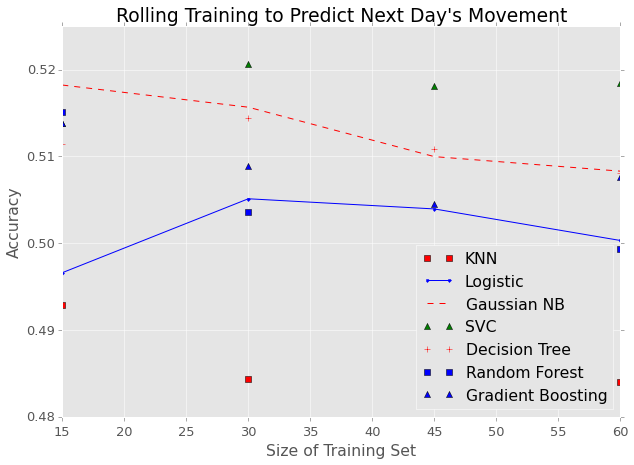

In [238]:
#Unnormalized

import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 13})

fig = plt.figure(figsize=(10, 7), dpi=100)

clf_roll_KNN = KNeighborsClassifier( n_neighbors = 8 )
train_ranges, accuracy_test_roll_logit = calc_rolling_accuracy(clf_roll_KNN)
plt.plot(train_ranges, accuracy_test_roll_logit,'rs', label='KNN')

print ('KNN Done')

clf_roll_logit = LogisticRegression(C = 0.5, random_state=1)
train_ranges, accuracy_test_roll_logit = calc_rolling_accuracy(clf_roll_logit)
plt.plot(train_ranges, accuracy_test_roll_logit,'.b-', label='Logistic')

print ('Logit Done')

model_NB = GaussianNB()
train_ranges, accuracy_test_roll_logit = calc_rolling_accuracy(model_NB)
plt.plot(train_ranges, accuracy_test_roll_logit,'r--', label='Gaussian NB')

print ('NB Done')

model_SVC = SVC(random_state=1)
train_ranges, accuracy_test_roll_logit = calc_rolling_accuracy(model_SVC)
plt.plot(train_ranges, accuracy_test_roll_logit,'g^', label='SVC')

print ('SVC Done')

model_DT = DecisionTreeClassifier(random_state=1)
train_ranges, accuracy_test_roll_logit = calc_rolling_accuracy(model_DT)
plt.plot(train_ranges, accuracy_test_roll_logit,'r+', label='Decision Tree')

print ('DT Done')

model_RF = RandomForestClassifier(random_state=1)
train_ranges, accuracy_test_roll_logit = calc_rolling_accuracy(model_RF)
plt.plot(train_ranges, accuracy_test_roll_logit,'bs', label='Random Forest')

print ('RF Done')

model_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
train_ranges, accuracy_test_roll_logit = calc_rolling_accuracy(model_GB)
plt.plot(train_ranges, accuracy_test_roll_logit,'b^', label='Gradient Boosting')

print ('BGM Done')

#plt.figure(figsize=(8, 5))
plt.legend(loc='lower right')

plt.title("Rolling Training to Predict Next Day's Movement")
plt.xlabel('Size of Training Set')
plt.ylabel('Accuracy')

trying
trying
trying
trying
trying
trying
trying
trying
trying
trying
KNN Done
trying
trying
trying
trying
trying
trying
trying
trying
trying
trying
Logit Done
trying
trying
trying
trying
trying
trying
trying
trying
trying
trying
NB Done
trying
trying
trying
trying
trying
trying
trying
trying
trying
trying
SVC Done
trying
trying
trying
trying
trying
trying
trying
trying
trying
trying
DT Done
trying
trying
trying
trying
trying
trying
trying
trying
trying
trying
RF Done
trying
trying
trying
trying
trying
trying
trying
trying
trying
trying
BGM Done


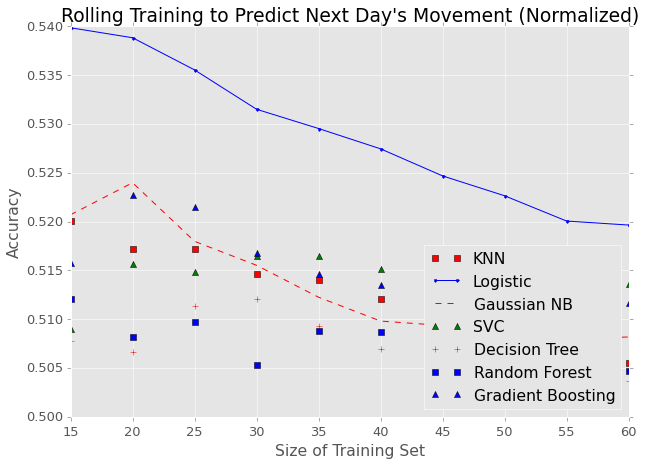

In [266]:
# Normalized

import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 13})

fig = plt.figure(figsize=(10, 7), dpi=100)

clf_roll_KNN = KNeighborsClassifier( n_neighbors = 8 )
train_ranges, accuracy_test_roll_logit = calc_norm_rolling_accuracy(clf_roll_KNN)
plt.plot(train_ranges, accuracy_test_roll_logit,'rs', label='KNN')

print ('KNN Done')

clf_roll_logit = LogisticRegression(C = 0.5, random_state=1)
train_ranges, accuracy_test_roll_logit = calc_norm_rolling_accuracy(clf_roll_logit)
plt.plot(train_ranges, accuracy_test_roll_logit,'.b-', label='Logistic')

print ('Logit Done')

model_NB = GaussianNB()
train_ranges, accuracy_test_roll_logit = calc_norm_rolling_accuracy(model_NB)
plt.plot(train_ranges, accuracy_test_roll_logit,'r--', label='Gaussian NB')

print ('NB Done')

model_SVC = SVC(random_state=1)
train_ranges, accuracy_test_roll_logit = calc_norm_rolling_accuracy(model_SVC)
plt.plot(train_ranges, accuracy_test_roll_logit,'g^', label='SVC')

print ('SVC Done')

model_DT = DecisionTreeClassifier(random_state=1)
train_ranges, accuracy_test_roll_logit = calc_norm_rolling_accuracy(model_DT)
plt.plot(train_ranges, accuracy_test_roll_logit,'r+', label='Decision Tree')

print ('DT Done')

model_RF = RandomForestClassifier(random_state=1)
train_ranges, accuracy_test_roll_logit = calc_norm_rolling_accuracy(model_RF)
plt.plot(train_ranges, accuracy_test_roll_logit,'bs', label='Random Forest')

print ('RF Done')

model_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
train_ranges, accuracy_test_roll_logit = calc_norm_rolling_accuracy(model_GB)
plt.plot(train_ranges, accuracy_test_roll_logit,'b^', label='Gradient Boosting')

print ('BGM Done')

#plt.figure(figsize=(8, 5))
plt.legend(loc='lower right')

plt.title("Rolling Training to Predict Next Day's Movement (Normalized)")
plt.xlabel('Size of Training Set')
plt.ylabel('Accuracy')

In [258]:
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 13})

def calc_one_accuracy(class_model):
    accuracy_train_roll_logit = []
    indiv_accuracy_test_roll_logit = []
    accuracy_test_roll_logit = []

    #train_ranges = [20]
    train_ranges = range(15, 25, 10)


    for train_range in train_ranges:
        for n in range( (len(df_X)) - train_range):
            #preprocessing.scale(df_X)
            class_model.fit(df_X[n:n+train_range], df_Y[n:n+train_range])
            # Make class predictions for all observations in X
            predicted_labels_test_logit = class_model.predict(df_X[n+train_range:n+train_range+1])
            # Compare predicted class labels with actual class labels
            
            atrain_roll_logit = class_model.score(df_X[n:n+train_range], df_Y[n:n+train_range])
            accuracy_train_roll_logit.append(atrain_roll_logit)
            atest_roll_logit = class_model.score(df_X[n+train_range:n+train_range+1], df_Y[n+train_range:n+train_range+1])
            indiv_accuracy_test_roll_logit.append(atest_roll_logit)

            #print accuracy_train_roll
        rolling_test_acc_logit = sum(indiv_accuracy_test_roll_logit) / len(indiv_accuracy_test_roll_logit)
        accuracy_test_roll_logit.append(rolling_test_acc_logit)
    return train_ranges, accuracy_test_roll_logit

def calc_norm_one_accuracy(class_model):
    accuracy_train_roll_logit = []
    indiv_accuracy_test_roll_logit = []
    accuracy_test_roll_logit = []

    #train_ranges = [20]
    train_ranges = range(15, 25, 10)

    for train_range in train_ranges:
        for n in range( (len(df_X)) - train_range):
            df_X_input_norm = pd.DataFrame( preprocessing.scale(df_X[n:n+train_range]) )
            class_model.fit(df_X_input_norm, df_Y[n:n+train_range])
            # Make class predictions for all observations in X
            df_X_predict_norm = pd.DataFrame( preprocessing.scale(df_X[n+1:n+train_range+1]) )
            predicted_labels_test_logit = class_model.predict(df_X_predict_norm.tail(1))
            # Compare predicted class labels with actual class labels
            
            atrain_roll_logit = class_model.score(df_X_input_norm, df_Y[n:n+train_range])
            accuracy_train_roll_logit.append(atrain_roll_logit)
            atest_roll_logit = class_model.score(df_X_predict_norm.tail(1), df_Y[n+train_range:n+train_range+1])
            indiv_accuracy_test_roll_logit.append(atest_roll_logit)

            #print accuracy_train_roll
        rolling_test_acc_logit = sum(indiv_accuracy_test_roll_logit) / len(indiv_accuracy_test_roll_logit)
        accuracy_test_roll_logit.append(rolling_test_acc_logit)
    return train_ranges, accuracy_test_roll_logit


#markets = ['Chg_5_Yr_Yield', 'Chg_10_yr_Yield', 'Chg_30_yr_Yield', 'Chg_GLD', 'Chg_OIL', 'Chg_SP500']
markets = ['Chg_OIL']


print ('Unnormalized')
    
#for market in markets:

#    print market

#    ymatrix = Y_Data_Diffs_Shifted[market].as_matrix()

#    df_X = X_Data_Diffs_Shifted
#    df_Y = ymatrix



    #Unnormalized

#    clf_roll_KNN = KNeighborsClassifier( n_neighbors = 8 )
#    train_ranges, accuracy_test_roll_logit = calc_one_accuracy(clf_roll_KNN)

#    print ('KNN: ', accuracy_test_roll_logit[0])

#    clf_roll_logit = LogisticRegression(C = 0.5, random_state=1)
#    train_ranges, accuracy_test_roll_logit = calc_one_accuracy(clf_roll_logit)

#    print ('Logit: ', accuracy_test_roll_logit[0])

#    model_NB = GaussianNB()
#    train_ranges, accuracy_test_roll_logit = calc_one_accuracy(model_NB)

#    print ('NB Done: ', accuracy_test_roll_logit[0])

#    model_SVC = SVC(random_state=1)
#    train_ranges, accuracy_test_roll_logit = calc_one_accuracy(model_SVC)

#    print ('SVC Done: ', accuracy_test_roll_logit[0])

#    model_DT = DecisionTreeClassifier(random_state=1)
#    train_ranges, accuracy_test_roll_logit = calc_one_accuracy(model_DT)

#    print ('DT Done: ', accuracy_test_roll_logit[0])

#    model_RF = RandomForestClassifier(random_state=1)
#    train_ranges, accuracy_test_roll_logit = calc_one_accuracy(model_RF)

#    print ('RF Done: ', accuracy_test_roll_logit[0])

#    model_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
#    train_ranges, accuracy_test_roll_logit = calc_one_accuracy(model_GB)

#    print ('BGM Done: ', accuracy_test_roll_logit[0])
    
    
print ('Normalized')
    
for market in markets:

    print market

    ymatrix = Y_Data_Diffs_Shifted[market].as_matrix()

    df_X = X_Data_Diffs_Shifted
    df_Y = ymatrix



    #Normalized

    clf_roll_KNN = KNeighborsClassifier( n_neighbors = 8 )
    train_ranges, accuracy_test_roll_logit = calc_norm_one_accuracy(clf_roll_KNN)

    print ('KNN: ', accuracy_test_roll_logit[0])

    clf_roll_logit = LogisticRegression(C = 0.5, random_state=1)
    train_ranges, accuracy_test_roll_logit = calc_norm_one_accuracy(clf_roll_logit)

    print ('Logit: ', accuracy_test_roll_logit[0])

    model_NB = GaussianNB()
    train_ranges, accuracy_test_roll_logit = calc_norm_one_accuracy(model_NB)

    print ('NB Done: ', accuracy_test_roll_logit[0])

    model_SVC = SVC(random_state=1)
    train_ranges, accuracy_test_roll_logit = calc_norm_one_accuracy(model_SVC)

    print ('SVC Done: ', accuracy_test_roll_logit[0])

    model_DT = DecisionTreeClassifier(random_state=1)
    train_ranges, accuracy_test_roll_logit = calc_norm_one_accuracy(model_DT)

    print ('DT Done: ', accuracy_test_roll_logit[0])

    model_RF = RandomForestClassifier(random_state=1)
    train_ranges, accuracy_test_roll_logit = calc_norm_one_accuracy(model_RF)

    print ('RF Done: ', accuracy_test_roll_logit[0])

    model_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    train_ranges, accuracy_test_roll_logit = calc_norm_one_accuracy(model_GB)

    print ('BGM Done: ', accuracy_test_roll_logit[0])

Unnormalized
Normalized
Chg_OIL
('KNN: ', 0.52007411982705376)
('Logit: ', 0.53983940704138356)
('NB Done: ', 0.52069178505250158)
('SVC Done: ', 0.50895614576899317)
('DT Done: ', 0.50772081531809754)
('RF Done: ', 0.51204447189623226)
('BGM Done: ', 0.51575046324891904)
